<a href="https://colab.research.google.com/github/mnocerino23/NBA-Player-Classifier/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In this notebook we experiment with K-Nearest Neighbors to tune multi-class classification models for NBA Salary prediction

In [88]:
import pandas as pd
import sklearn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# Read in the training and testing data that we preprocessed and split in the previous Jupyter Notebook
nba_train = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/NBA/nba_train.csv')
nba_test = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/NBA/nba_test.csv')

In [90]:
nba_train.shape

(314, 52)

In [91]:
nba_test.shape

(79, 52)

# Break Players into 4 classes based on their salary
With some experimentation this was the best 4 class division I was able to find

1.   0-6 Million: Role Player
2.   6-12 Million: Average
3.   12-20 Million: Star
4.   20+ Million: Max



In [92]:
nba_train['class'] = ''
for index, row in nba_train.iterrows():
  if nba_train.at[index,'Salary'] <= 6:
    nba_train.at[index,'class'] = 'Role Player'
  elif nba_train.at[index,'Salary'] > 6 and nba_train.at[index,'Salary'] <= 12:
    nba_train.at[index,'class'] = 'Average'
  elif nba_train.at[index, 'Salary'] > 12 and nba_train.at[index,'Salary'] <= 20:
    nba_train.at[index,'class'] = 'Star'
  elif nba_train.at[index,'Salary']> 20:
    nba_train.at[index,'class'] = 'Max'

In [93]:
print(nba_train['class'].value_counts())

Role Player    170
Average         55
Star            45
Max             44
Name: class, dtype: int64


In [94]:
nba_test['class'] = ''
for index, row in nba_test.iterrows():
  if nba_test.at[index,'Salary'] <= 6:
    nba_test.at[index,'class'] = 'Role Player'
  elif nba_test.at[index,'Salary'] > 6 and nba_test.at[index,'Salary'] <= 12:
    nba_test.at[index,'class'] = 'Average'
  elif nba_test.at[index, 'Salary'] > 12 and nba_test.at[index,'Salary'] <= 20:
    nba_test.at[index,'class'] = 'Star'
  elif nba_test.at[index,'Salary'] > 20:
    nba_test.at[index,'class'] = 'Max'

In [95]:
print(nba_test['class'].value_counts())

Role Player    38
Max            16
Average        15
Star           10
Name: class, dtype: int64


In [96]:
nba_train = nba_train.drop(['Salary'], axis = 1)
nba_test = nba_test.drop(['Salary'], axis = 1)

In [97]:
#seperate the other features from the target feature class (which is a class rank based on the salary of the player)
nba_train_features = nba_train.drop(['class'], axis = 1)
nba_train_target = nba_train['class']

nba_test_features = nba_test.drop(['class'], axis = 1)
nba_test_target = nba_test['class']

In [98]:
print('Train:')
print('train_features dimensions: ', nba_train_features.shape)
print('train_target dimensions: ', nba_train_target.shape, '\n')


print('Test:')
print('test_features dimensions: ', nba_test_features.shape)
print('test_target dimensions: ', nba_test_target.shape)

Train:
train_features dimensions:  (314, 51)
train_target dimensions:  (314,) 

Test:
test_features dimensions:  (79, 51)
test_target dimensions:  (79,)


In [99]:
print(len(nba_train_features.columns))
print(nba_train_features.columns)

51
Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'pos_C', 'pos_PF',
       'pos_PG', 'pos_SF', 'pos_SG'],
      dtype='object')


# Feature Selection
*   Determine the most relevant of the 51 features in the dataset for predicting player salary using SelectKBest in Scikit-Learn


In [100]:
from sklearn.feature_selection import SelectKBest, f_classif

In [101]:
top_features_ordered = []

From some experimentation, we find that KNN works best with 27 of the most important features selected

In [102]:
best_features = SelectKBest(f_classif, k=27)
k_best_data = best_features.fit_transform(nba_train_features, nba_train_target)
mask = best_features.get_support()
new_features = nba_train_features.columns[mask]
for item in new_features:
  if item not in top_features_ordered:
    top_features_ordered.append(item)

In [103]:
count = 1
for item in top_features_ordered:
  print(count, '. ', item)
  count += 1

1 .  Age
2 .  GS
3 .  MP
4 .  FG
5 .  FGA
6 .  3P
7 .  3PA
8 .  2P
9 .  2PA
10 .  FT
11 .  FTA
12 .  DRB
13 .  TRB
14 .  AST
15 .  STL
16 .  TOV
17 .  PF
18 .  PTS
19 .  PER
20 .  AST%
21 .  USG%
22 .  OWS
23 .  DWS
24 .  WS
25 .  OBPM
26 .  BPM
27 .  VORP


# K-Nearest-Neighbours Classifier

In [104]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=18, metric = 'manhattan').fit(nba_train_features[top_features_ordered],nba_train_target)

[[ 2  2  7  4]
 [ 0 14  0  2]
 [ 2  0 34  2]
 [ 2  1  3  4]]


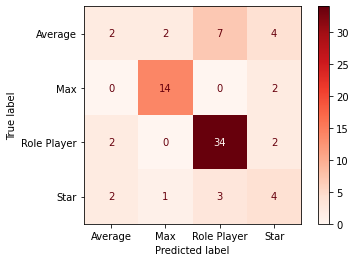

In [106]:
disp = ConfusionMatrixDisplay.from_estimator(
        knn,
        nba_test_features[top_features_ordered],
        nba_test_target,
        cmap=plt.cm.Reds,
    )

print(disp.confusion_matrix)

In [107]:
y_pred = knn.predict(nba_test_features[top_features_ordered])
print(accuracy_score(y_pred, nba_test_target))

0.6835443037974683


# Now, tune the model by finding the best hyperparameters for KNN classifier with GridSearch CV



In [108]:
from sklearn.model_selection import GridSearchCV

In [109]:
best_knn = GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33],
    'metric': ['manhattan','minkowski','euclidean'],
}, cv = 5, scoring = 'accuracy', return_train_score = False)
best_knn.fit(nba_train_features[top_features_ordered], nba_train_target)
pd.DataFrame(best_knn.cv_results_)[['param_n_neighbors', 'param_metric', 'params', 'mean_test_score','rank_test_score']].sort_values(by = ['rank_test_score'])[0:5]

,param_n_neighbors,param_metric,params,mean_test_score,rank_test_score
9,10,manhattan,"{'metric': 'manhattan', 'n_neighbors': 10}",0.716436,1
6,7,manhattan,"{'metric': 'manhattan', 'n_neighbors': 7}",0.703789,2
8,9,manhattan,"{'metric': 'manhattan', 'n_neighbors': 9}",0.703738,3
11,12,manhattan,"{'metric': 'manhattan', 'n_neighbors': 12}",0.700461,4
75,10,euclidean,"{'metric': 'euclidean', 'n_neighbors': 10}",0.700461,5
